In [1]:
from pathlib import Path

# Calibration folder
cal_dir = Path(r"C:\HydroUSGS\MODFLOW_USGS\models\model.calibration\calibration")

# MF-NWT executable (adjust if using md_mfnwt_x64.exe)
exe = Path(r"C:\HydroUSGS\MODFLOW_USGS\bin\mfnwt.exe")

print("Executable exists:", exe.exists(), exe)
print("Calibration dir exists:", cal_dir.exists(), cal_dir)


Executable exists: True C:\HydroUSGS\MODFLOW_USGS\bin\mfnwt.exe
Calibration dir exists: True C:\HydroUSGS\MODFLOW_USGS\models\model.calibration\calibration


In [2]:
lst_files = list(cal_dir.glob("*.lst")) + list(cal_dir.glob("*.LIST")) + list(cal_dir.glob("*.list"))
print("LST files found:", [p.name for p in lst_files])

if lst_files:
    lst = lst_files[0]
    text = lst.read_text(errors="ignore")
    lines = text.splitlines()

    print("\n--- LST Diagnostics (ERROR / STOP / SEVERE) ---\n")
    for ln in lines:
        u = ln.upper()
        if "ERROR" in u or "STOP" in u or "SEVERE" in u:
            print(ln)
else:
    print("⚠️ No LST file found.")


LST files found: ['UMD_f.lst']

--- LST Diagnostics (ERROR / STOP / SEVERE) ---



In [ ]:
import shutil

oc     = cal_dir / "UMD_f.oc"
oc_bak = cal_dir / "UMD_f.oc.bak_clean"

print("OC exists:", oc.exists(), "size:", oc.stat().st_size if oc.exists() else None)
print("Backup OC exists:", oc_bak.exists())

if oc_bak.exists():
    shutil.copy2(oc_bak, oc)
    print("✔ Restored clean OC file.")
else:
    print("⚠️ Backup clean OC file not found.")


In [3]:
import subprocess

print("Running:", exe)
print("Working directory:", cal_dir)

res = subprocess.run(
    [str(exe), "umd_fb.nam"], 
    cwd=str(cal_dir),
    capture_output=True,
    text=True
)

print("✔ Model run completed.")
print("Return code:", res.returncode)

if res.stdout:
    print("\nSTDOUT:\n", res.stdout[:5000])
if res.stderr:
    print("\nSTDERR:\n", res.stderr[:5000])


Running: C:\HydroUSGS\MODFLOW_USGS\bin\mfnwt.exe
Working directory: C:\HydroUSGS\MODFLOW_USGS\models\model.calibration\calibration
✔ Model run completed.
Return code: 0

STDOUT:
 
                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.8 09/01/2013                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 03/06/2014                       

 Using NAME file: umd_fb.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/16 15:11:57

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwat

In [5]:
def human(n):
    for u in ["B","KB","MB","GB","TB"]:
        if n < 1024: 
            return f"{n:.0f} {u}"
        n /= 1024
    return f"{n:.1f} PB"

print("📁 UMD* output files:\n")
for p in sorted(cal_dir.glob("UMD*")):
    print(f"{p.name:22s} {human(p.stat().st_size):>8s}")


📁 UMD* output files:

umd.bas                   661 B
UMD.CBC.bin                9 GB
umd.dis                  182 KB
umd.ets                    1 MB
UMD.fls                  375 MB
umd.gfb                    3 MB
UMD.hds                    1 GB
umd.hyd                    9 KB
UMD.hydmod.bin             2 MB
umd.lpf                    1 KB
umd.nwt                   725 B
UMD.pqm                  139 MB
UMD.qaq                    1 GB
UMD.stg                   98 MB
umd.swi                    1 KB
umd.swr                    2 MB
umd.wel                  733 KB
UMD.zta                    1 GB
UMD_f.lst                134 MB
umd_f.oc                 291 KB
UMD_f.oc.bak              330 B
UMD_f.oc.bak_clean       291 KB
umd_fb.nam                 5 KB
umd_fb.nam.bak             4 KB
umd_fb.nam.bak_clean       5 KB
umd_fb.nam.bak_paths       5 KB
umd_obs.drn              910 KB
umd_obs.ghb              910 KB


In [6]:
from flopy.utils import HeadFile
import numpy as np

hds = cal_dir / "UMD.hds"

print("HDS exists:", hds.exists(), "size:", hds.stat().st_size)

hf = HeadFile(str(hds))
kstpkper = hf.get_kstpkper()

print("Saved timesteps:", len(kstpkper))
print("First 5:", kstpkper[:5])
print("Last 5 :", kstpkper[-5:])

# Final simulated heads
H_last = hf.get_data(kstpkper=kstpkper[-1])
print("Head array shape:", H_last.shape)
print("Mean head (layer 1):", float(np.nanmean(H_last[0])))


HDS exists: True size: 1255786800
Saved timesteps: 5479
First 5: [(np.int32(0), np.int32(0)), (np.int32(0), np.int32(1)), (np.int32(0), np.int32(2)), (np.int32(0), np.int32(3)), (np.int32(0), np.int32(4))]
Last 5 : [(np.int32(0), np.int32(5474)), (np.int32(0), np.int32(5475)), (np.int32(0), np.int32(5476)), (np.int32(0), np.int32(5477)), (np.int32(0), np.int32(5478))]
Head array shape: (3, 189, 101)
Mean head (layer 1): 169.6652374267578


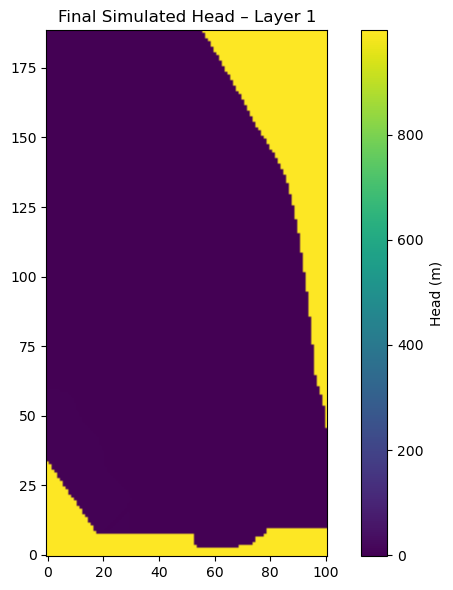

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.imshow(H_last[0], origin="lower")
plt.colorbar(label="Head (m)")
plt.title("Final Simulated Head – Layer 1")
plt.tight_layout()
plt.show()


In [8]:
from flopy.utils import CellBudgetFile

cbc = cal_dir / "UMD.CBC.bin"
print("CBC exists:", cbc.exists(), "size:", cbc.stat().st_size)

cbf = CellBudgetFile(str(cbc))
labels = sorted({rec.strip() for rec in cbf.get_unique_record_names()})

print("📘 CBC record types (first 20):")
for lab in labels[:20]:
    print(" •", lab)


CBC exists: True size: 9683653552
📘 CBC record types (first 20):
 • b'AG. WATER USE'
 • b'CONSTANT HEAD'
 • b'DRAINS'
 • b'ET SEGMENTS'
 • b'FLOW FRONT FACE'
 • b'FLOW LOWER FACE'
 • b'FLOW RIGHT FACE'
 • b'HEAD DEP BOUNDS'
 • b'NEXRAD RAINFALL'
 • b'REC. IRRIGAT.'
 • b'SEPTIC RETURN'
 • b'STORAGE'
 • b'SWR GWET'
 • b'SWR LEAKAGE'
 • b'WELLS'


In [9]:
hmin = float(np.nanmin(H_last[0]))
hmax = float(np.nanmax(H_last[0]))
hmean = float(np.nanmean(H_last[0]))

print("Layer 1 min:", hmin)
print("Layer 1 max:", hmax)
print("Layer 1 mean:", hmean)


Layer 1 min: -2.2694664001464844
Layer 1 max: 999.0
Layer 1 mean: 169.6652374267578


In [10]:
from pathlib import Path

cal_dir = Path(r"C:\HydroUSGS\MODFLOW_USGS\models\model.calibration\calibration")
lst = cal_dir / "UMD_f.lst"

print("LST exists:", lst.exists(), "size (MB):", lst.stat().st_size / (1024**2))

text = lst.read_text(errors="ignore")
up = text.upper()

for key in ["NORMAL TERMINATION", "ABNORMAL TERMINATION", "FAILED"]:
    print(f"\n--- Searching for '{key}' ---")
    if key in up:
        start = up.index(key)
        print(text[max(0, start-200): start+200])
    else:
        print("Not found.")


LST exists: True size (MB): 133.6753168106079

--- Searching for 'NORMAL TERMINATION' ---
Not found.

--- Searching for 'ABNORMAL TERMINATION' ---
Not found.

--- Searching for 'FAILED' ---
Not found.


In [11]:
from flopy.utils import HeadFile
import numpy as np

hds = cal_dir / "UMD.hds"
hf = HeadFile(str(hds))
kstpkper = hf.get_kstpkper()

print("Number of saved time steps:", len(kstpkper))
print("First 3:", kstpkper[:3])
print("Last 3:", kstpkper[-3:])

H_last = hf.get_data(kstpkper=kstpkper[-1])
print("Head array shape:", H_last.shape)
print("Min / Max / Mean (layer 1):",
      float(np.nanmin(H_last[0])),
      float(np.nanmax(H_last[0])),
      float(np.nanmean(H_last[0])))


Number of saved time steps: 5479
First 3: [(np.int32(0), np.int32(0)), (np.int32(0), np.int32(1)), (np.int32(0), np.int32(2))]
Last 3: [(np.int32(0), np.int32(5476)), (np.int32(0), np.int32(5477)), (np.int32(0), np.int32(5478))]
Head array shape: (3, 189, 101)
Min / Max / Mean (layer 1): -2.2694664001464844 999.0 169.6652374267578


In [12]:
from flopy.utils import CellBudgetFile

cbc = cal_dir / "UMD.CBC.bin"
cbf = CellBudgetFile(str(cbc))

labels = sorted({rec.strip() for rec in cbf.get_unique_record_names()})
print("CBC record types:")
for lab in labels:
    print(" •", lab)

print("\nTotal timesteps in CBC:", len(cbf.get_kstpkper()))


CBC record types:
 • b'AG. WATER USE'
 • b'CONSTANT HEAD'
 • b'DRAINS'
 • b'ET SEGMENTS'
 • b'FLOW FRONT FACE'
 • b'FLOW LOWER FACE'
 • b'FLOW RIGHT FACE'
 • b'HEAD DEP BOUNDS'
 • b'NEXRAD RAINFALL'
 • b'REC. IRRIGAT.'
 • b'SEPTIC RETURN'
 • b'STORAGE'
 • b'SWR GWET'
 • b'SWR LEAKAGE'
 • b'WELLS'

Total timesteps in CBC: 5479


In [14]:
H1 = H_last[0]

# Mask criteria for real heads only
mask = (H1 < 900) & (H1 > -100) & (np.abs(H1) < 1e20)

hmin = float(np.nanmin(H1[mask]))
hmax = float(np.nanmax(H1[mask]))
hmean = float(np.nanmean(H1[mask]))

print("Masked Layer 1 min/max/mean:", hmin, hmax, hmean)



Masked Layer 1 min/max/mean: -2.2694664001464844 1.885106086730957 0.37694135308265686


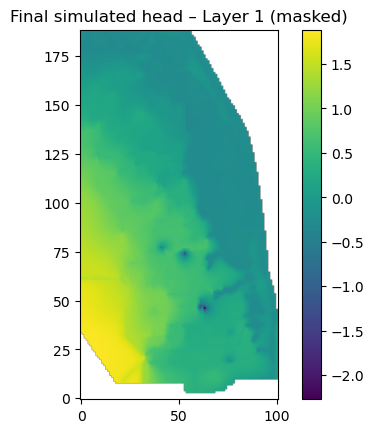

In [15]:
plt.imshow(np.where(mask, H1, np.nan),
           origin="lower",
           vmin=hmin, vmax=hmax)
plt.colorbar()
plt.title("Final simulated head – Layer 1 (masked)")
plt.show()
